# BEE 4880 Final Project 
Ada Lian and Adam Kulaczkowski 

# ---March--- #

## Current economic dispatch

In [53]:
# load necessary packages
import Pkg; Pkg.add("PrettyTables"); Pkg.add("VegaLite")
using JuMP, GLPK
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
ENV["COLUMNS"]=120;

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [54]:
gen_info = CSV.read("Generators_data.csv", DataFrame);
fuels = CSV.read("Fuels_data.csv", DataFrame);
loads_march = CSV.read("NYISO_March_2019_Hourly_Demand.csv", DataFrame);
loads_august = CSV.read("NYISO_August_2019_Hourly_Demand.csv", DataFrame);
gen_variable_march = CSV.read("Generators_variability_March.csv", DataFrame);
gen_variable_august = CSV.read("Generators_variability_August.csv", DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads_march, loads_august, gen_variable_march, gen_variable_august]
    rename!(f,lowercase.(names(f)))
end

In [55]:
# Keep only the columns relevant to our ED model 
# (We'll come back to other columns in our unit commitment notebooks)
select!(gen_info, 1:10) # columns 1:10 and cluster IDs
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df.fuel_cost[ismissing.(gen_df[:,:fuel_cost])] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar):
gen_df[!, :is_variable] .= false
gen_df[in(["WT","PV","OWT"]).(gen_df.resource),:is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.resource);

In [56]:
gen_df

700×14 DataFrame
 Row │ r_id      resource  name                       existing_cap_mw  num_units  cap_size  var_om_cost_per_mwh  var_o ⋯
     │ Float64?  String?   String?                    Float64?         Float64?   Float64?  Float64?             Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │      1.0  CC        Astoria Energy 2 - CC3               330.0        1.0     330.0                  3.0        ⋯
   2 │      2.0  CC        Astoria Energy 2 - CC4               330.0        1.0     330.0                  3.0
   3 │      3.0  CC        Astoria East Energy - CC1            320.0        1.0     320.0                  3.0
   4 │      4.0  CC        Astoria East Energy - CC2            320.0        1.0     320.0                  3.0
   5 │      5.0  ST        Astoria 2                            180.0        1.0     180.0                  3.0        ⋯
   6 │      6.0  ST        Astoria 3                            376.0        1.0     376.0                  3.0
   7 │      7.0  ST        Astoria 5                            387.0        1.0     387.0                  3.0
   8 │      8.0  GT        Astoria GT 01                         16.0        1.0      16.0                  7.0
   9 │      9.0  GT        Gowanus 1-1                           20.0        1.0      20.0                  7.0        ⋯
  10 │     10.0  GT        Gowanus 1-2                           20.0        1.0      20.0                  7.0
  11 │     11.0  GT        Gowanus 1-3                           20.0        1.0      20.0                  7.0
  ⋮  │    ⋮         ⋮                  ⋮                     ⋮             ⋮         ⋮               ⋮                 ⋱
 691 │    691.0  ST        Somerset                             655.1        1.0     655.1                  3.0
 692 │    692.0  ES        Beacon LESR                           20.0        1.0      20.0                  0.0        ⋯
 693 │    693.0  WT        Orangeville Wind Farm                 93.9        1.0      93.9                  0.0
 694 │    694.0  GT        Freeport CT 1                         60.0        1.0      60.0                  7.0
 695 │    695.0  CC        Saranac Energy                       285.6        1.0     285.6                  3.0
 696 │    696.0  HY        Chateaugay High Falls                  1.7        1.0       1.7                  0.0        ⋯
 697 │    697.0  WT        Western NY Wind Power                  6.6        1.0       6.6                  0.0
 698 │    698.0  ST        Wheelabrator Hudson Falls             14.4        1.0      14.4                  3.0
 699 │    699.0  ST        Wheelabrator Westchester              59.7        1.0      59.7                  3.0
 700 │    700.0  OWT       Empire Wind                            0.0        1.0       0.0                  0.0        ⋯
                                                                                          7 columns and 679 rows omitted

In [57]:
CSV.write("gen_df.csv",gen_df)

"gen_df.csv"

In [58]:
gen_variable_long_march = stack(gen_variable_march, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);
# Now we have a "long" dataframe; 
# let's look at the first 6 entries of a wind resource for example
#first(gen_variable_long[gen_variable_long.gen_full.=="wec_sdge_onshore_wind_turbine_1.0",:],6)

In [59]:
gen_variable_long_march

2187×3 DataFrame
  Row │ hour   gen_full  cf      
      │ Int64  String    Float64 
──────┼──────────────────────────
    1 │     1  pv          0.0
    2 │     2  pv          0.0
    3 │     3  pv          0.0
    4 │     4  pv          0.0
    5 │     5  pv          0.0
    6 │     6  pv          0.0
    7 │     7  pv          0.0
    8 │     8  pv          0.086
    9 │     9  pv          0.284
   10 │    10  pv          0.47
   11 │    11  pv          0.549
  ⋮   │   ⋮       ⋮         ⋮
 2178 │   720  owt         0.8
 2179 │   721  owt         0.79
 2180 │   722  owt         0.778
 2181 │   723  owt         0.758
 2182 │   724  owt         0.752
 2183 │   725  owt         0.776
 2184 │   726  owt         0.686
 2185 │   727  owt         0.604
 2186 │   728  owt         0.624
 2187 │   729  owt         0.576
                2166 rows omitted

In [60]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi(gen_df, loads, gen_variable)
    ED = Model(GLPK.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    # This requires a few extra steps because we are indexing decision variables over two sets: generator and time
    solution = DataFrame(value.(GEN).data)
    ax1 = value.(GEN).axes[1]
    ax2 = value.(GEN).axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    
    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        status = termination_status(ED)
    )

end

economic_dispatch_multi (generic function with 1 method)

In [42]:
#solve a month's economic dispatch (March and August)
T_period_march = 1:nrow(loads_march)

loads_march = loads_march[in.(loads_march.hour,Ref(T_period_march)),:]
gen_variable_march = gen_variable_long_march[in.(gen_variable_long_march.hour,Ref(T_period_march)),:]

2187×3 DataFrame
  Row │ hour   gen_full  cf      
      │ Int64  String    Float64 
──────┼──────────────────────────
    1 │     1  pv          0.0
    2 │     2  pv          0.0
    3 │     3  pv          0.0
    4 │     4  pv          0.0
    5 │     5  pv          0.0
    6 │     6  pv          0.0
    7 │     7  pv          0.0
    8 │     8  pv          0.086
    9 │     9  pv          0.284
   10 │    10  pv          0.47
   11 │    11  pv          0.549
  ⋮   │   ⋮       ⋮         ⋮
 2178 │   720  owt         0.8
 2179 │   721  owt         0.79
 2180 │   722  owt         0.778
 2181 │   723  owt         0.758
 2182 │   724  owt         0.752
 2183 │   725  owt         0.776
 2184 │   726  owt         0.686
 2185 │   727  owt         0.604
 2186 │   728  owt         0.624
 2187 │   729  owt         0.576
                2166 rows omitted

In [ ]:
solution_march = economic_dispatch_multi(gen_df, loads_march, gen_variable_march);

In [ ]:
sol_gen_march = innerjoin(solution_march.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_march = combine(groupby(sol_gen_march, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_march, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)

In [ ]:
sol_gen_sum = combine(groupby(sol_gen_march, [:resource]), :gen_sum => sum)

In [ ]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
percentage = sol_gen_sum[6,:gen_sum_sum]/tot_demand*100 
print("The percentage of total demand can be met using wind is ", percentage, "%")

In [ ]:
sol_gen_march |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [ ]:
sol_gen_march |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})

In [ ]:
solution_march.cost

## Offshore Wind Expansion

In [ ]:
gen_df_otw = copy(gen_df)
gen_df_otw[gen_df_otw.resource .== "OWT",:existing_cap_mw] .= 4300
solution_march_otw = economic_dispatch_multi(gen_df_otw, loads_march, gen_variable_march);

## Deactivation of Nuclear Power Plant 

In [ ]:
gen_df_np = copy(gen_df)
gen_df_np[gen_df_np.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_np[gen_df_np.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_march_np = economic_dispatch_multi(gen_df_np, loads_march, gen_variable_march);

## Wind Energy Expansion and Deactivation of Indian Point 

In [ ]:
gen_df_combine = copy(gen_df)
gen_df_combine[gen_df_combine.resource .== "OWT",:existing_cap_mw] .= 2490
gen_df_combine[gen_df_combine.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_combine[gen_df_combine.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_march_combine = economic_dispatch_multi(gen_df_combine, loads_march, gen_variable_march);

# ---August--- #

## Current Economic Dispatch 

In [61]:
gen_variable_long_august = stack(gen_variable_august, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);

In [62]:
T_period_august = 1:nrow(loads_august)

gen_variable_august = gen_variable_long_august[in.(gen_variable_long_august.hour,Ref(T_period_august)),:]
loads_august = loads_august[in.(loads_august.hour,Ref(T_period_august)),:]

744×2 DataFrame
 Row │ hour   demand  
     │ Int64  Float64 
─────┼────────────────
   1 │     1  19032.1
   2 │     2  18112.7
   3 │     3  17491.5
   4 │     4  17132.6
   5 │     5  17114.7
   6 │     6  17654.2
   7 │     7  18786.9
   8 │     8  20214.4
   9 │     9  21371.6
  10 │    10  22138.6
  11 │    11  22959.0
  ⋮  │   ⋮       ⋮
 735 │   735  19123.7
 736 │   736  19360.1
 737 │   737  19551.5
 738 │   738  19704.5
 739 │   739  19378.9
 740 │   740  18977.0
 741 │   741  18736.0
 742 │   742  18081.2
 743 │   743  17225.1
 744 │   744  15027.9
      723 rows omitted

In [63]:
solution_august = economic_dispatch_multi(gen_df, loads_august, gen_variable_august);

In [64]:
sol_gen_august = innerjoin(solution_august.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_august = combine(groupby(sol_gen_august, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_august, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)

10416×3 DataFrame
   Row │ resource  hour   gen_sum  
       │ String?   Int64  Float64  
───────┼───────────────────────────
     1 │ CC            1  6266.11
     2 │ CG            1     0.0
     3 │ ES            1    50.0
     4 │ GT            1     0.0
     5 │ HY            1  5326.3
     6 │ IC            1    18.8
     7 │ JE            1     0.0
     8 │ NB            1  2922.8
     9 │ NP            1  2925.0
    10 │ OWT           1     0.0
    11 │ PS            1  1400.0
   ⋮   │    ⋮        ⋮       ⋮
 10407 │ HY          744  5326.3
 10408 │ IC          744     0.0
 10409 │ JE          744     0.0
 10410 │ NB          744  2922.8
 10411 │ NP          744  2925.0
 10412 │ OWT         744     0.0
 10413 │ PS          744  1400.0
 10414 │ PV          744     0.0
 10415 │ ST          744     0.0
 10416 │ WT          744   436.766
                 10395 rows omitted

In [65]:
sol_gen_sum = combine(groupby(sol_gen_august, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum    
     │ String?   Float64        
─────┼──────────────────────────
   1 │ CC             5.10612e6
   2 │ ST         67659.5
   3 │ GT             0.0
   4 │ JE             2.85555e5
   5 │ HY             3.96277e6
   6 │ WT        210273.0
   7 │ IC         26781.5
   8 │ NP             2.1762e6
   9 │ NB             2.17456e6
  10 │ ES         37200.0
  11 │ PV          8542.4
  12 │ PS             1.0416e6
  13 │ CG            10.8
  14 │ OWT            0.0

In [85]:
tot_demand = sum(sol_gen_sum[!,:gen_sum_sum]) 
percentage_ren = (sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum])/tot_demand*100 
print("The percentage of total demand that is renewable is ", percentage_ren, "%")

The percentage of total demand that is renewable is 34.84327462074683%

In [94]:
percentage_ren_nuc = (sol_gen_sum[10,:gen_sum_sum]+sol_gen_sum[5,:gen_sum_sum]+sol_gen_sum[6,:gen_sum_sum]+
    sol_gen_sum[11,:gen_sum_sum]+sol_gen_sum[12,:gen_sum_sum]+sol_gen_sum[14,:gen_sum_sum]+
    sol_gen_sum[8,:gen_sum_sum]+sol_gen_sum[9,:gen_sum_sum])/tot_demand*100 
print("The percentage of total demand that is renewable is ", percentage_ren_nuc, "%")

The percentage of total demand that is renewable is 63.661489370232516%

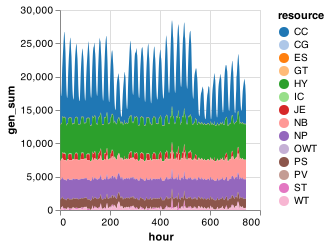

In [67]:
sol_gen_august |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

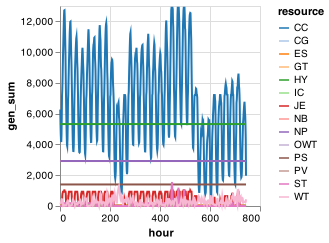

In [68]:
sol_gen_august |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})

In [69]:
solution_august.cost

1.6759500333262524e8

## Offshore Wind Expansion 

In [70]:
gen_df_otw = copy(gen_df)
gen_df_otw[gen_df_otw.resource .== "OWT",:existing_cap_mw] .= 4300
solution_august_otw = economic_dispatch_multi(gen_df_otw, loads_august, gen_variable_august);

In [73]:
sol_gen_august_otw = innerjoin(solution_august_otw.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_august_otw = combine(groupby(sol_gen_august_otw, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_august_otw, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)
sol_gen_sum_otw = combine(groupby(sol_gen_august_otw, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum    
     │ String?   Float64        
─────┼──────────────────────────
   1 │ CC             4.62988e6
   2 │ ST         50305.8
   3 │ GT             0.0
   4 │ JE             2.48766e5
   5 │ HY             3.96277e6
   6 │ WT        210273.0
   7 │ IC         24471.2
   8 │ NP             2.16639e6
   9 │ NB             2.16664e6
  10 │ ES         37200.0
  11 │ PV          8542.4
  12 │ PS             1.0416e6
  13 │ CG             7.2
  14 │ OWT            5.50434e5

In [87]:
tot_demand_otw = sum(sol_gen_sum_otw[!,:gen_sum_sum]) 
percentage_ren_otw = (sol_gen_sum_otw[10,:gen_sum_sum]+sol_gen_sum_otw[5,:gen_sum_sum]+sol_gen_sum_otw[6,:gen_sum_sum]+
    sol_gen_sum_otw[11,:gen_sum_sum]+sol_gen_sum_otw[12,:gen_sum_sum]+sol_gen_sum_otw[14,:gen_sum_sum])/tot_demand_otw*100 
print("The percentage of total demand that is renewable is ", percentage_ren_otw, "%")

The percentage of total demand that is renewable is 38.489195121477444%

In [96]:
percentage_ren_otw_nuc = (sol_gen_sum_otw[10,:gen_sum_sum]+sol_gen_sum_otw[5,:gen_sum_sum]+sol_gen_sum_otw[6,:gen_sum_sum]+
    sol_gen_sum_otw[11,:gen_sum_sum]+sol_gen_sum_otw[12,:gen_sum_sum]+sol_gen_sum_otw[14,:gen_sum_sum]+
    sol_gen_sum_otw[8,:gen_sum_sum]+sol_gen_sum_otw[9,:gen_sum_sum])/tot_demand_otw*100 
print("The percentage of total demand that is renewable is ", percentage_ren_otw_nuc, "%")

The percentage of total demand that is renewable is 67.18989761412656%

In [93]:
percentage_otw =sol_gen_sum_otw[14,:gen_sum_sum]/tot_demand_otw*100 
print("The percentage of total demand that is offshore wind is ", percentage_otw, "%")

The percentage of total demand that is offshore wind is 3.645920500730595%

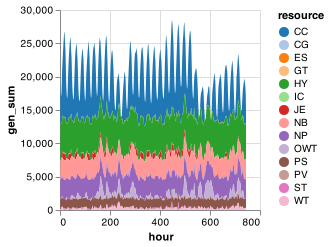

In [75]:
sol_gen_august_otw |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [84]:
solution_august_otw.cost

1.5480890818054703e8

## Deactivation of Nuclear Power Plant

In [71]:
gen_df_np = copy(gen_df)
gen_df_np[gen_df_np.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_np[gen_df_np.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_august_np = economic_dispatch_multi(gen_df_np, loads_august, gen_variable_august);

In [76]:
sol_gen_august_np = innerjoin(solution_august_np.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_august_np = combine(groupby(sol_gen_august_np, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_august_np, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)
sol_gen_sum_np = combine(groupby(sol_gen_august_np, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum    
     │ String?   Float64        
─────┼──────────────────────────
   1 │ CC             6.53133e6
   2 │ ST             1.93314e5
   3 │ GT             0.0
   4 │ JE             4.38342e5
   5 │ HY             3.96277e6
   6 │ WT        210273.0
   7 │ IC         42480.2
   8 │ NP        456816.0
   9 │ NB             2.17456e6
  10 │ ES         37200.0
  11 │ PV          8542.4
  12 │ PS             1.0416e6
  13 │ CG            37.0
  14 │ OWT            0.0

In [88]:
tot_demand_np = sum(sol_gen_sum_np[!,:gen_sum_sum]) 
percentage_ren_np = (sol_gen_sum_np[10,:gen_sum_sum]+sol_gen_sum_np[5,:gen_sum_sum]+sol_gen_sum_np[6,:gen_sum_sum]+
    sol_gen_sum_np[11,:gen_sum_sum]+sol_gen_sum_np[12,:gen_sum_sum]+sol_gen_sum_np[14,:gen_sum_sum])/tot_demand_np*100 
print("The percentage of total demand that is renewable is ", percentage_ren_np, "%")

The percentage of total demand that is renewable is 34.84327462074684%

In [97]:
percentage_ren_np_nuc = (sol_gen_sum_np[10,:gen_sum_sum]+sol_gen_sum_np[5,:gen_sum_sum]+sol_gen_sum_np[6,:gen_sum_sum]+
    sol_gen_sum_np[11,:gen_sum_sum]+sol_gen_sum_np[12,:gen_sum_sum]+sol_gen_sum_np[14,:gen_sum_sum]+
    sol_gen_sum_np[8,:gen_sum_sum]+sol_gen_sum_np[9,:gen_sum_sum])/tot_demand_np*100 
print("The percentage of total demand that is renewable is ", percentage_ren_np_nuc, "%")

The percentage of total demand that is renewable is 52.27278006313223%

In [92]:
percentage_otw_np =sol_gen_sum_np[14,:gen_sum_sum]/tot_demand_np*100 
print("The percentage of total demand that is offshore wind is ", percentage_otw_np, "%")

The percentage of total demand that is offshore wind is 0.0%

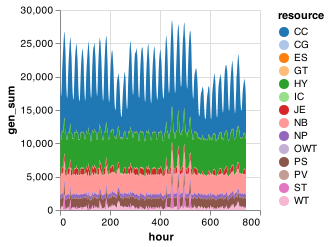

In [78]:
sol_gen_august_np |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [83]:
solution_august_np.cost

1.9414789844860733e8

## Wind Energy Expansion and Deactivation of Indian Point

In [72]:
gen_df_combine = copy(gen_df)
gen_df_combine[gen_df_combine.resource .== "OWT",:existing_cap_mw] .= 4300
gen_df_combine[gen_df_combine.name .== "Indian Point 2",:existing_cap_mw] .= 0
gen_df_combine[gen_df_combine.name .== "Indian Point 3",:existing_cap_mw] .= 0
solution_august_combine = economic_dispatch_multi(gen_df_combine, loads_august, gen_variable_august);

In [79]:
sol_gen_august_combine = innerjoin(solution_august_combine.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen_august_combine = combine(groupby(sol_gen_august_combine, [:resource, :hour]), 
            :gen => sum)

# Reorder resources
sort!(sol_gen_august_combine, [:hour, :resource])
#CSV.write("sol_gen_btm.csv",sol_gen_march)
sol_gen_sum_combine = combine(groupby(sol_gen_august_combine, [:resource]), :gen_sum => sum)

14×2 DataFrame
 Row │ resource  gen_sum_sum    
     │ String?   Float64        
─────┼──────────────────────────
   1 │ CC             6.08564e6
   2 │ ST             1.40523e5
   3 │ GT             0.0
   4 │ JE             3.89404e5
   5 │ HY             3.96277e6
   6 │ WT        210273.0
   7 │ IC         39472.6
   8 │ NP        456816.0
   9 │ NB             2.17456e6
  10 │ ES         37200.0
  11 │ PV          8542.4
  12 │ PS             1.0416e6
  13 │ CG            30.8
  14 │ OWT            5.50434e5

In [89]:
tot_demand_combine = sum(sol_gen_sum_combine[!,:gen_sum_sum]) 
percentage_ren_combine = (sol_gen_sum_combine[10,:gen_sum_sum]+sol_gen_sum_combine[5,:gen_sum_sum]+
    sol_gen_sum_combine[6,:gen_sum_sum]+sol_gen_sum_combine[11,:gen_sum_sum]+sol_gen_sum_combine[12,:gen_sum_sum]+
    sol_gen_sum_combine[14,:gen_sum_sum])/tot_demand_combine*100 
print("The percentage of total demand that is renewable is ", percentage_ren_combine, "%")

The percentage of total demand that is renewable is 38.489195121477444%

In [98]:
percentage_ren_combine_nuc = (sol_gen_sum_combine[10,:gen_sum_sum]+sol_gen_sum_combine[5,:gen_sum_sum]+
    sol_gen_sum_combine[6,:gen_sum_sum]+sol_gen_sum_combine[11,:gen_sum_sum]+sol_gen_sum_combine[12,:gen_sum_sum]+
    sol_gen_sum_combine[14,:gen_sum_sum]+sol_gen_sum_combine[8,:gen_sum_sum]+sol_gen_sum_combine[9,:gen_sum_sum])/tot_demand_combine*100 
print("The percentage of total demand that is renewable is ", percentage_ren_combine_nuc, "%")

The percentage of total demand that is renewable is 55.918700563862835%

In [91]:
percentage_otw_combine =sol_gen_sum_combine[14,:gen_sum_sum]/tot_demand_combine*100 
print("The percentage of total demand that is offshore wind is ", percentage_otw_combine, "%")

The percentage of total demand that is offshore wind is 3.645920500730595%

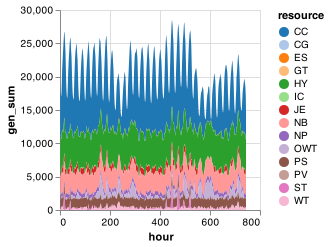

In [81]:
sol_gen_august_combine |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}})

In [82]:
solution_august_combine.cost

1.8080720244034675e8